In [12]:
import pandas as pd
import matplotlib.pyplot as plt


In [13]:
df = pd.read_csv('logfiles/data_1692368875_1714382790.csv')
df.head()

,Time (UNIX Localtime format),Voltage 1 (V),Voltage 2 (V),Current (A),Power (W),Temperature (°C),SOC (%),Power Status
0,1692368875,13.659,0.010,-10.456,-142.82,17.25,NaN,OFF
1,1692368876,13.661,0.010,-10.465,-142.96,17.25,NaN,OFF
2,1692368877,13.662,0.012,-10.506,-143.53,17.25,NaN,OFF
3,1692368878,13.659,0.010,-10.469,-143.00,17.25,NaN,OFF
4,1692368879,13.661,0.009,-10.436,-142.57,17.25,NaN,OFF


In [14]:
df[" Temperature (°C)"].min(), df[" Temperature (°C)"].max()

(-4.5, 25.0)

In [15]:
df["Time"] = pd.to_datetime(df["Time (UNIX Localtime format)"], unit='s')
df.shape

(741399, 9)

In [16]:
df_filter = df[df.Time.diff().dt.seconds == 30.0]
df_filter = df_filter.set_index('Time')

In [17]:
daily_max = df_filter[" Temperature (°C)"].groupby(df_filter.index.day).max()
daily_min = df_filter[" Temperature (°C)"].groupby(df_filter.index.day).min()

In [18]:
daily_min.min()

-4.5

Text(0, 0.5, ' Temperature (°C)')

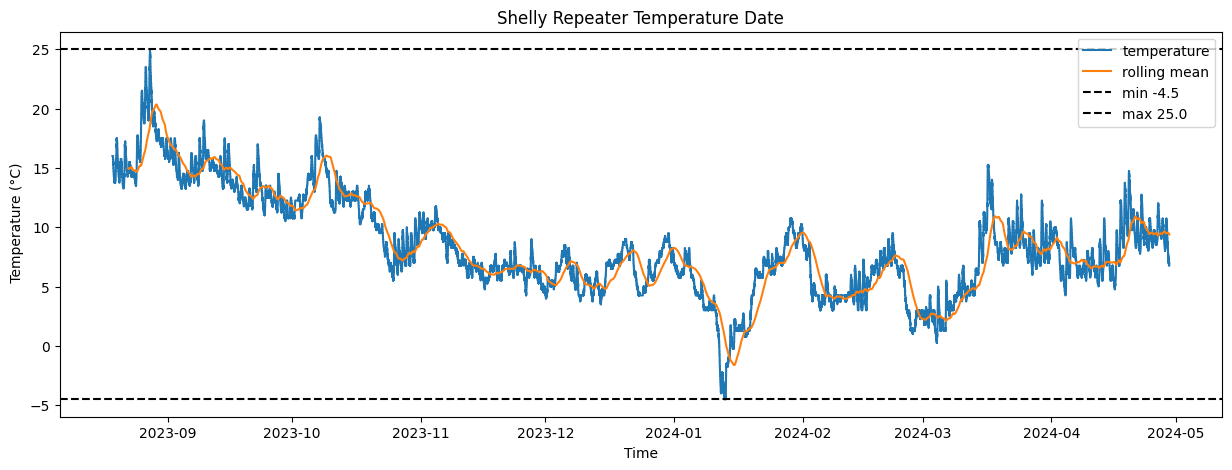

In [19]:
key = " Temperature (°C)"
plt.figure(figsize=(15, 5))
plt.plot(df_filter[key], label='temperature')
# plot a rolling mean of the timeseries
plt.plot(df_filter[key].rolling(window=3*60*60).mean(), label='rolling mean')
# horizontal lines at min and max
plt.axhline(y=daily_min.min(), color='black', linestyle='--', label=f'min {df_filter[key].min()}')
plt.axhline(y=daily_max.max(), color='black', linestyle='--', label=f'max {df_filter[key].max()}')
plt.legend()
plt.title("Shelly Repeater Temperature Date")
plt.xlabel("Time")
plt.ylabel(key)


Text(0, 0.5, ' Voltage 1 (V)')

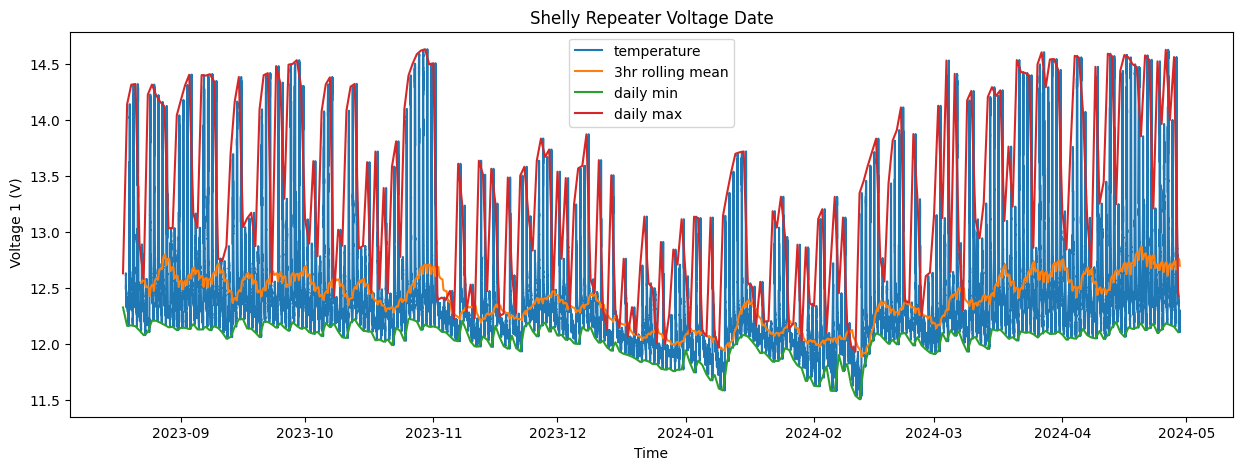

In [20]:
key = " Voltage 1 (V)"
plt.figure(figsize=(15, 5))
plt.plot(df_filter[key], label='temperature')
# plot a rolling mean of the timeseries
plt.plot(df_filter[key].rolling(window=3*60*60).mean(), label='3hr rolling mean')
plt.plot(df_filter[key].resample('D').min(), label='daily min')
plt.plot(df_filter[key].resample('D').max(), label='daily max')
# horizontal lines at min and max
plt.legend()
plt.title("Shelly Repeater Voltage Date")
plt.xlabel("Time")
plt.ylabel(key)

# Rolling power

\begin{equation}
DEFECIT  = \int\frac{\Delta P}{\Delta t}dt
\end{equation}

In [21]:
floating_charge = 12.6
float_mask = df_filter[" Voltage 1 (V)"] > floating_charge
df_filter["Rolling Charge State"] = df_filter[" Power (W)"].diff()
df_filter["float_mask"] = float_mask

# add unique id to each group of consecutive True values
df_filter['float_mask'] = df_filter['float_mask'].ne(df_filter['float_mask'].shift()).cumsum()

rolling = df_filter.groupby('float_mask')['Rolling Charge State'].cumsum()
roller = rolling.rolling(window=3*60*60).mean()
df_filter["defecit"] = roller

AttributeError: 'Axes' object has no attribute 'ylabel'

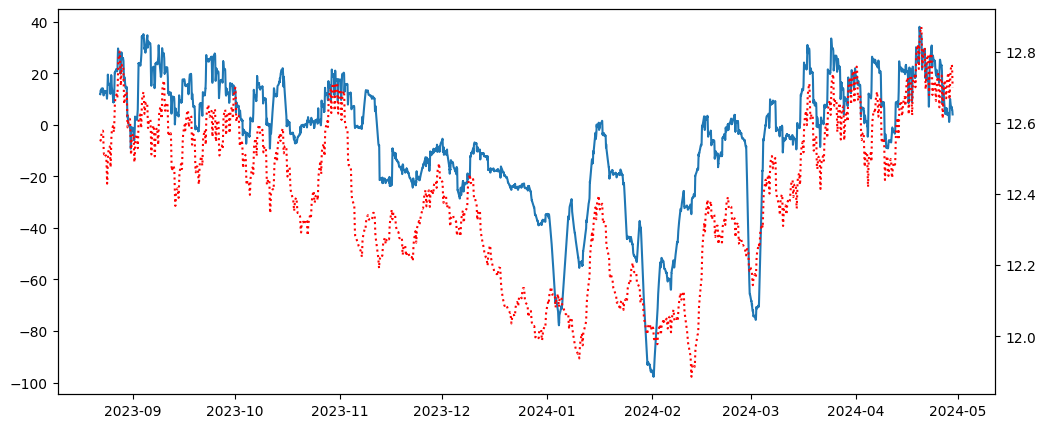

In [50]:
fig, ax = plt.subplots(figsize=(15, 5))
fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.

p1, = ax.plot(roller, label=f"Defecit (W), Minimum: {roller.min():.2f}W", )
p2, = twin1.plot(df_filter[" Voltage 1 (V)"].rolling(window=3*60*60).mean(), label="Battery Voltage (V)", color="red", linestyle=":")

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())

ax.tick_params(axis='y', colors=p1.get_color())
twin1.tick_params(axis='y', colors=p2.get_color())

ax.legend(handles=[p1, p2])
plt.title(f"Shelly Repeater Battery Voltage and Defecit Assuming Float {floating_charge:.2f}V")

plt.show()